# 2/ Advanced chatbot with message history and filter using Langchain and DBRX Instruct

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/chatbot-rag/llm-rag-self-managed-flow-2.png?raw=true" style="float: right; margin-left: 10px"  width="900px;">

Our Vector Search Index is now ready!

Let's now create a more advanced langchain model to perform RAG.

We will improve our langchain model with the following:

- Build a complete chain supporting a chat history, using Databricks DBRX Instruct input style
- Add a filter to only answer Databricks-related questions
- Compute the embeddings with Databricks BGE models within our chain to query the self-managed Vector Search Index

<!-- Collect usage data (view). Remove it to disable collection or disable tracker during installation. View README for more details.  -->
<img width="1px" src="https://ppxrzfxige.execute-api.us-west-2.amazonaws.com/v1/analytics?category=data-science&org_id=429769148865153&notebook=%2F03-advanced-app%2F02-Advanced-Chatbot-Chain&demo_name=llm-rag-chatbot&event=VIEW&path=%2F_dbdemos%2Fdata-science%2Fllm-rag-chatbot%2F03-advanced-app%2F02-Advanced-Chatbot-Chain&version=1">

In [0]:
%run "./0. Init"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lakehouse 0.20.0 requires packaging==24.1, but you have packaging 23.2 which is incompatible.
lakehouse 0.20.0 requires requests==2.32.3, but you have requests 2.31.0 which is incompatible.
lakehouse 0.20.0 requires urllib3==2.2.2, but you have urllib3 2.0.7 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-core 0.2.5 requires packaging<24.0,>=23.2, but you have packaging 24.1 which is incompatible.
pdfservices-sdk 4.0.0 requires requests~=2.31.0, but you have requests 2.32.3 which is incompatible.
lakehouse 0.20.0 requires certifi==2024.

/local_disk0/.ephemeral_nfs/envs/pythonEnv-a4df616d-560c-431b-b32c-526df79434df/lib/python3.11/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


[NOTICE] Using a notebook authentication token. Recommended for development only. For improved performance, please use Service Principal based authentication. To disable this message, pass disable_notice=True to VectorSearchClient().


DataFrame[]

In [0]:
import mlflow
import yaml

In [0]:
system_message = "You are a trusted assistant that helps answer questions based only on the provided information. If you do not know the answer to a question, you truthfully say you do not know. Questions will be related to maintenance on trailers and trucks. Any question not related to the topic must be ignored. Here is some context which might or might not help you answer: {context}.  Answer directly, do not repeat the question, do not start with something like: the answer to the question, do not add AI in front of your answer, do not say: here is the answer, do not mention the context or the question."
#  Based on this context, answer this question: {question}"

In [0]:
rag_chain_config = {
    "databricks_resources": {
        # "llm_endpoint_name": "dbrx_instruct",
        "llm_endpoint_name": "databricks-meta-llama-3-1-70b-instruct",
        "vector_search_endpoint_name": VECTOR_SEARCH_ENDPOINT_NAME,
    },
    "input_example": {
        "messages": [
            # {"role": "user", "content": "What is a drum brake?"},
            # {"role": "assistant", "content": "A drum brake is a brake that uses friction caused by a set of shoes or pads that press outward against a rotating bowl-shaped part called a brake drum."},
            {"role": "user", "content": "How can I install brake pads?"}
        ]
    },
    "output_example": """
        Lorem ipsum dolor sit amet, consectetur adipiscing elit. 
        Ut erat mi, pretium ac aliquam vitae, fermentum at risus. 
        Ut faucibus, lorem sit amet iaculis auctor, odio lacus cursus mauris, ut ornare erat mauris id nibh. 
        Curabitur nulla magna, posuere quis fermentum sit amet, maximus eu mi.
    """,
    "llm_config": {
        "llm_parameters": {"max_tokens": 1500, "temperature": 0.01},
        "llm_prompt_template": system_message,
        "llm_prompt_template_variables": ["context", "question"],
    },
    "retriever_config": {
        "embedding_model": "databricks-gte-large-en",
        "chunk_template": "Passage: {chunk_text}\nSource: Page {page_nr} from {document_uri}\n",
        "data_pipeline_tag": "poc",
        "parameters": {"k": 3, "query_type": "ann"},
        "schema": {"chunk_text": "content", "document_uri": "url", "primary_key": "id", "page_nr": "page_number"},
        "vector_search_index": VS_INDEX_FULLNAME.replace('`', ''),
        "uri_prefix": BASE_URL,
    },
}
try:
    with open(CHAIN_CONFIG_FILE, 'w') as f:
        yaml.dump(rag_chain_config, f)
except:
    print('pass to work on build job')

## Exploring Langchain capabilities

Let's start with the basics and send a query to a Databricks Foundation Model using LangChain.

In [0]:
%%writefile chain.py
from langchain_community.embeddings import DatabricksEmbeddings
from operator import itemgetter
import mlflow
import os
import json

from databricks.vector_search.client import VectorSearchClient

from langchain_community.chat_models import ChatDatabricks
from langchain_community.vectorstores import DatabricksVectorSearch

from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnablePassthrough, RunnableBranch
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import (
    PromptTemplate,
    ChatPromptTemplate,
    MessagesPlaceholder,
)
from langchain_core.messages import HumanMessage, AIMessage
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.agents.react.agent import create_react_agent
from langchain_community.tools.databricks import UCFunctionToolkit

from PIL import Image
import pymupdf
import base64
import requests

## Enable MLflow Tracing
mlflow.langchain.autolog()



#### VARIABLES

# Load the chain's configuration
model_config = mlflow.models.ModelConfig(development_config="rag_chain_config.yaml")

databricks_resources = model_config.get("databricks_resources")
retriever_config = model_config.get("retriever_config")
llm_config = model_config.get("llm_config")

# Connect to the Vector Search Index
vs_client = VectorSearchClient(disable_notice=True)
vs_index = vs_client.get_index(
    endpoint_name=databricks_resources.get("vector_search_endpoint_name"),
    index_name=retriever_config.get("vector_search_index"),
)
vector_search_schema = retriever_config.get("schema")

embedding_model = DatabricksEmbeddings(endpoint=retriever_config.get("embedding_model"))

# Turn the Vector Search index into a LangChain retriever
vector_search_as_retriever = DatabricksVectorSearch(
    vs_index,
    text_column=vector_search_schema.get("chunk_text"),
    embedding=embedding_model, 
    columns=[
        vector_search_schema.get("primary_key"),
        vector_search_schema.get("chunk_text"),
        vector_search_schema.get("document_uri"),
        vector_search_schema.get("page_nr")
    ],
).as_retriever(search_kwargs=retriever_config.get("parameters"))

CATALOG_NAME = "`test-catalog`"
SCHEMA_NAME = "bronze"
TABLE_PATH = "{}.{}.".format(CATALOG_NAME, SCHEMA_NAME) + "{table_name}"



#### METHODS

# Return the string contents of the most recent message from the user
def extract_question(chat_messages_array):
    return chat_messages_array[-1]["content"]

# Return the chat history, which is is everything before the last question
def extract_chat_history(chat_messages_array):
    last_n = 5 # always use an even number to capture both questions and answers in the chat history
    return chat_messages_array[-last_n:-1] if chat_messages_array[-1]["role"] == "user" else chat_messages_array[-last_n:]

# Format the converastion history to fit into the prompt template below.
def format_chat_history_for_prompt(chat_messages_array):
    ## TODO: summarize older messages and append the last pair of user-assistant messages
    history = extract_chat_history(chat_messages_array)
    formatted_chat_history = []
    if len(history) > 0:
        for chat_message in history:
            if chat_message["role"] == "user":
                formatted_chat_history.append(HumanMessage(content=chat_message["content"]))
            elif chat_message["role"] == "assistant":
                formatted_chat_history.append(AIMessage(content=chat_message["content"]))
    return formatted_chat_history

# Method to update the chat history with new messages
def update_chat_history(inputs):
    chat_messages_array = inputs['chat_history']
    chat_messages_array.append({"role": "user", "content": inputs['question']})
    chat_messages_array.append({"role": "assistant", "content": inputs['answer']})
    return chat_messages_array

# Method to format the docs returned by the retriever into the prompt
# This puts together all the answers retrieved from the vector index into a single string
def format_context(docs):
    chunk_template = retriever_config.get("chunk_template")
    chunk_contents = [
        chunk_template.format(
            chunk_text=d.page_content,
            document_uri=d.metadata[vector_search_schema.get("document_uri")],
            page_nr=d.metadata[vector_search_schema.get("page_nr")],
        )
        for d in docs
    ]
    return "".join(chunk_contents)

def get_page_image_bytes(url: str, page_number: int) -> str:
    pdf_path = './doc.pdf'
    try:
        pdf = requests.get(url)
    except:
        return ""
    with open(pdf_path, 'wb') as f:
        f.write(pdf.content)
    doc = pymupdf.open(pdf_path)
    page = doc[page_number]
    pix = page.get_pixmap(dpi=300)
    # return Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    img = pix.tobytes("png")  # Convert to PNG bytes
    return base64.b64encode(img).decode()  # Convert to base64 and decode to string

def combine_references(outputs):
    refs = set()
    for var, output in outputs.items():
        if 'references' in var:
            for ref in output:
                refs.add((ref.metadata['id'], ref.page_content, retriever_config.get("uri_prefix") + ref.metadata['url'].split('/')[-1], ref.metadata['page_number'], ref.metadata['url'].replace("dbfs:", "")))

    references = []
    for _, content, url, page_nr, pdf_path in refs:
        references.append(dict(zip(["content", "doc_uri", "page_number", "img_base64"], [content, url, int(page_nr)+1, get_page_image_bytes(url, int(page_nr))])))

    return references


# def combine_references(outputs):
#     refs = set()
#     for var, output in outputs.items():
#         if 'references' in var:
#             for ref in output:
#                 refs.add((ref.metadata['id'], ref.page_content, retriever_config.get("uri_prefix") + ref.metadata['url'].split('/')[-1], ref.metadata['page_number']))

#     references = []
#     for _, content, url, page_nr, pdf_path in refs:
#         references.append(dict(zip(["content", "doc_uri", "page_number"], [content, url, int(page_nr)+1])))

#     return references

def get_tools(wh_id, catalog='`dev-gold`', schema="maggie_hackathon"):
    return (
        UCFunctionToolkit(warehouse_id=wh_id)
        # Include functions as tools using their qualified names.
        # You can use "{catalog_name}.{schema_name}.*" to get all functions in a schema.
        .include(f"{catalog.replace('`', '')}.{schema}.*")
        .get_tools()
    )


#### PROMPTS

# Prompt Template for generation
full_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", llm_config.get("llm_prompt_template")),
        # Note: This chain does not compress the history, so very long converastions can overflow the context window.
        MessagesPlaceholder(variable_name="formatted_chat_history"),
        # User's most current question
        ("user", "{question}"),
    ]
)

full_prompt_and_rewrite = ChatPromptTemplate.from_messages(
    [
        ("system", llm_config.get("llm_prompt_template") + """Your answer must contain a list of tools, a list of parts and a series of steps needed to accomplish the actions outlined in the provided context.
        Additionally, list out some safety advice related to the required steps and tools used.
        List tools, parts, and steps that are only mentioned in the context. 
        If any step requires sub-steps, list them too. Do not add explanation. 
        Include as many details as possible.

        Example:
            Context:
                To replace brake pads on a trailer you need to first remove the wheel and the slider bolt with a torx wrench (T25, BPW no. 02.0130.44.10). 
                Next, pivot the caliper up and slide out the old brake pads. Then, slide in the new brake pads and retract the pistons. 
                To check if you did replaced them correctly, you can monitor the brake fluid level. Finally, reposition the caliper and reinstall the slider bolt.
            Question: How do I replace brake pads on a trailer?
            Restructured Answer:
                Here is what you need to replace brake pads on a trailer. 
                
                Tools required:
                    - torx wrench (T25, BPW no. 02.0130.44.10)
                
                Parts required:
                    - new brake pads
                    - (optional) new brake fluid
                    
                Steps required:
                    1. Remove the wheel.
                        1.1 Use the jack to lift the trailer up.
                    2. Remove the slider bolt.
                    3. Pivot the caliper up.
                    4. Slide out the old brake pads.
                    5. Replace the retaining clips.
                    6. Slide in the new brake pads.
                    7. Retract the pistons.
                    8. Monitor the brake fluid level.
                    9. Reposition the caliper.
                    10. Reinstall the slider bolt.
                        10.1 Tighten the bolts a bit while the trailer is up. 
                        10.2 Lower the trailer, then lower the jack and finally tighten the bolts completely.

                Safety advice:
                    - Ensure the trailer is securely parked: Park the trailer on a flat, stable surface and engage the parking brake to prevent movement.
                    - Wear protective gear: Use gloves, safety glasses, and sturdy work boots to protect your hands, eyes, and feet.
                    - Use proper lifting equipment: Use a jack rated for the weight of the trailer and jack stands to support it safely before removing the wheel.
                    - Avoid contact with hot components: Let the brakes cool down completely before starting the work to avoid burns from hot parts.
                    - Work in a well-ventilated area: If replacing brake fluid, work in a well-ventilated area to avoid inhaling fumes.
                    - Handle brake fluid carefully: Brake fluid is corrosive; avoid skin contact and clean spills immediately.
                    - Check for correct tool usage: Use the correct size Torx wrench (T25) to avoid stripping the bolts.
                    - Do not overfill the brake fluid reservoir: If adding brake fluid, ensure the level is correct to avoid pressure issues.
                    - Check brake function before use: After reassembly, pump the brake pedal to ensure proper brake function and check for leaks or unusual noises before moving the trailer.

        Restructured Answer:
        """),
        # Note: This chain does not compress the history, so very long converastions can overflow the context window.
        MessagesPlaceholder(variable_name="formatted_chat_history"),
        # User's most current question
        ("user", "{question}"),
    ]
)

# Prompt Template for generation with tools
prompt_with_tools = ChatPromptTemplate.from_messages(
    [
        # ("system", llm_config.get("llm_prompt_template")),
        # ("placeholder", "{chat_history}"),
        # ("human", "{input}"),
        # ("placeholder", "{agent_scratchpad}"),
        ("system", llm_config.get("llm_prompt_template") + """
            You have access to the following tools:

            {tools}

            Use the following format:

            Question: the input question you must answer
            Thought: you should always think about what to do
            Action: the action to take, should be one of [{tool_names}]
            Action Input: the input to the action
            Observation: the result of the action
            ... (this Thought/Action/Action Input/Observation can repeat N times)
            Thought: I now know the final answer
            Final Answer: the final answer to the original input question

            Begin!
        """),
        # Note: This chain does not compress the history, so very long converastions can overflow the context window.
        MessagesPlaceholder(variable_name="formatted_chat_history"),
        # User's most current question
        ("human", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

# Prompt Template for query rewriting to allow converastion history to work - this will translate a query such as "how does it work?" after a question such as "what is spark?" to "how does spark work?".
query_rewrite_prompt = PromptTemplate(
    template="""Based on the chat history below, we want you to generate a query for an external data source to retrieve relevant documents so that we can better answer the question. The query should be in natural language. The external data source uses similarity search to search for relevant documents in a vector space. So the query should be similar to the relevant documents semantically. Answer with only the query. Do not add explanation.

    Chat history: {chat_history}

    Question: {question}""",
    input_variables=["chat_history", "question"],
)

# Prompt Template for output rewriting - this will list tools required by the user to perform an action (example "replace brake pads" -> tools: - Wrenches - ...; steps: 1, 2, ...)
output_rewrite_prompt_sequential = PromptTemplate(
    template="""Based on the chat history below, we want you to restructure the answer into a list of tools, a list of parts and a series of steps needed to accomplish the actions outlined in the answer.
    Additionally, list out some safety advice related to the required steps and tools used.
    List tools, parts, and steps that are only mentioned in the answer. 
    If any step requires sub-steps, list them too. Do not add explanation. 
    Include as many details as possible.
    Answer directly, do not start with something like: here is the restructured answer.

    Example:
        Chat history:
            User: How do I replace brake pads on a trailer?
            Assistant: 
                To replace brake pads on a trailer you need to first remove the wheel and the slider bolt with a torx wrench (T25, BPW no. 02.0130.44.10). 
                Next, pivot the caliper up and slide out the old brake pads. Then, slide in the new brake pads and retract the pistons. 
                To check if you did replaced them correctly, you can monitor the brake fluid level. Finally, reposition the caliper and reinstall the slider bolt.
            User: What parts or components are needed?
                You need new brake pads of the same type as those that you will replace. Optionally, you may need new brake fluid from a compatible manufacturer.
        Restructured Answer:
            Here is what you need to replace brake pads on a trailer. 
            
            Tools required:
                - torx wrench (T25, BPW no. 02.0130.44.10)
            
            Parts required:
                - new brake pads
                - (optional) new brake fluid
                
            Steps required:
                1. Remove the wheel.
                    1.1 Use the jack to lift the trailer up.
                2. Remove the slider bolt.
                3. Pivot the caliper up.
                4. Slide out the old brake pads.
                5. Replace the retaining clips.
                6. Slide in the new brake pads.
                7. Retract the pistons.
                8. Monitor the brake fluid level.
                9. Reposition the caliper.
                10. Reinstall the slider bolt.
                    10.1 Tighten the bolts a bit while the trailer is up. 
                    10.2 Lower the trailer, then lower the jack and finally tighten the bolts completely.

            Safety advice:
                - Ensure the trailer is securely parked: Park the trailer on a flat, stable surface and engage the parking brake to prevent movement.
                - Wear protective gear: Use gloves, safety glasses, and sturdy work boots to protect your hands, eyes, and feet.
                - Use proper lifting equipment: Use a jack rated for the weight of the trailer and jack stands to support it safely before removing the wheel.
                - Avoid contact with hot components: Let the brakes cool down completely before starting the work to avoid burns from hot parts.
                - Work in a well-ventilated area: If replacing brake fluid, work in a well-ventilated area to avoid inhaling fumes.
                - Handle brake fluid carefully: Brake fluid is corrosive; avoid skin contact and clean spills immediately.
                - Check for correct tool usage: Use the correct size Torx wrench (T25) to avoid stripping the bolts.
                - Do not overfill the brake fluid reservoir: If adding brake fluid, ensure the level is correct to avoid pressure issues.
                - Check brake function before use: After reassembly, pump the brake pedal to ensure proper brake function and check for leaks or unusual noises before moving the trailer.

        Chat history: {chat_history}

        Restructured Answer:
    """,
    input_variables=["chat_history"],
)



#### CHAIN

# Model for generation
model = ChatDatabricks(
    endpoint=databricks_resources.get("llm_endpoint_name"),
    extra_params=llm_config.get("llm_parameters"),
)

model_parser = model | StrOutputParser()

# Tools and Agent
# tools = get_tools()
# model_with_tools = create_tool_calling_agent(model, tools, prompt_with_tools)
# model_with_tools = create_react_agent(model, tools, prompt_with_tools) 
# agent_executor = AgentExecutor(agent=model_with_tools, tools=tools, verbose=True)

# def agent_executor_wrapper(input_data):
#     # Wrapping the agent_executor invocation
#     question = input_data['question']
#     chat_history = input_data['formatted_chat_history']
#     result = agent_executor.invoke({"input": question, "formatted_chat_history": chat_history})
#     return result["output"]


# Chains
input_parser = RunnablePassthrough.assign(
    question=itemgetter("messages") | RunnableLambda(extract_question),
    chat_history=itemgetter("messages") | RunnableLambda(extract_chat_history),
    formatted_chat_history=itemgetter("messages") | RunnableLambda(format_chat_history_for_prompt),
)

vector_store_chain = RunnableBranch(
    ( #if there is a chat history, then re-write the question 
        lambda x: len(x["chat_history"]) > 0,
        query_rewrite_prompt | model_parser, 
    ), # else return the question as-is
    itemgetter("question"),
) | vector_search_as_retriever

prompt_inputs = (
    {
        "question": lambda x: x["question"],
        "chat_history": lambda x: x["chat_history"],
        "formatted_chat_history": lambda x: x["formatted_chat_history"],
        "context": lambda x: format_context(x["references"]),
    }
)

# main_prompt_inputs = (
#     {
#         "question": lambda x: x["main_question"],
#         "chat_history": lambda x: x["chat_history"],
#         "formatted_chat_history": lambda x: x["formatted_chat_history"],
#         "context": lambda x: format_context(x["main_references"]),
#     }
# )

# parts_prompt_inputs = (
#     {
#         "question": lambda x: x["parts_question"],
#         "chat_history": lambda x: x["chat_history"],
#         "formatted_chat_history": lambda x: x["formatted_chat_history"],
#         "context": lambda x: format_context(x["parts_references"]),
#     }
# )

# tools_prompt_inputs = (
#     {
#         "question": lambda x: x["tools_question"],
#         "chat_history": lambda x: x["chat_history"],
#         "formatted_chat_history": lambda x: x["formatted_chat_history"],
#         "context": lambda x: format_context(x["tools_references"]),
#     }
# )


all_prompt_inputs = (
    {
        "question": lambda x: x["tools_question"],
        "chat_history": lambda x: x["chat_history"],
        "formatted_chat_history": lambda x: x["formatted_chat_history"],
        "context": lambda x: "\n".join([format_context(x["main_references"]), format_context(x["parts_references"]), format_context(x["tools_references"])]),
    }
)

update_chat_history_passthrough = RunnablePassthrough.assign(chat_history=RunnableLambda(lambda x: update_chat_history(x))).assign(formatted_chat_history=itemgetter("chat_history") | RunnableLambda(format_chat_history_for_prompt))


# Additional question to make the LLM list out parts
parts_listing_question = RunnableLambda(lambda x: "\n".join([x["question"], "What compatible parts or components are needed?"]))
tools_listing_question = RunnableLambda(lambda x: "\n".join([x["question"], "What tools must be used?"]))


# chain = (
#     input_parser
#     | RunnablePassthrough.assign(references=vector_store_chain).assign(answer=prompt_inputs | full_prompt | model_parser)
#     | update_chat_history_passthrough.assign(original_question=itemgetter("question"), question=parts_listing_question) # update chat history and add new question for parts to the chain
#     | RunnablePassthrough.assign(
#         original_references=itemgetter("references"),
#         original_answer=itemgetter("answer"),
#         references=vector_store_chain
#     ).assign(answer=prompt_inputs | full_prompt | model_parser)
#     | update_chat_history_passthrough.assign(question=tools_listing_question) # update chat history and add new question for tools to the chain
#     | RunnablePassthrough.assign(
#         parts_references=itemgetter("references"),
#         parts_answer=itemgetter("answer"),
#         references=vector_store_chain
#     ).assign(answer=prompt_inputs | full_prompt | model_parser)
#     | update_chat_history_passthrough # update chat history before rewriting all the answers
#     .assign(answer=output_rewrite_prompt_sequential | model_parser)
#     | {
#         "answer": itemgetter("answer"),
#         "references": lambda x: combine_references(x),
#     }
#     | RunnableLambda(lambda x: dict((k, x[k]) for k in ["answer", "references"]))
#     | RunnableLambda(lambda x: json.dumps(x))
#     # | RunnableLambda(agent_executor_wrapper)  # Pass the query to the agent executor
#     # | RunnablePassthrough()
# )

chain = (
    input_parser
    | {
        "main_question": itemgetter("question"),
        "parts_question": parts_listing_question,
        "tools_question": tools_listing_question,
        "main_references": {"question": itemgetter("question"), "chat_history": itemgetter("chat_history")} | vector_store_chain,
        "parts_references": {"question": parts_listing_question, "chat_history": itemgetter("chat_history")} | vector_store_chain,
        "tools_references": {"question": tools_listing_question, "chat_history": itemgetter("chat_history")} | vector_store_chain,
        "chat_history": itemgetter("chat_history"),
        "formatted_chat_history": itemgetter("formatted_chat_history"),
    }
    # | RunnablePassthrough.assign(
    #     main_answer=main_prompt_inputs | full_prompt | model_parser, 
    #     parts_answer=parts_prompt_inputs | full_prompt | model_parser,
    #     tools_answer=tools_prompt_inputs | full_prompt | model_parser,
    # )
    # | RunnablePassthrough.assign(question=itemgetter("main_question"), answer=itemgetter("main_answer")) 
    # | update_chat_history_passthrough # update chat history
    # .assign(question=parts_listing_question, answer=itemgetter("parts_answer"))
    # | update_chat_history_passthrough # update chat history
    # .assign(question=tools_listing_question, answer=itemgetter("tools_answer")) 
    # | update_chat_history_passthrough # update chat history
    # .assign(answer=output_rewrite_prompt_sequential | model_parser)
    | RunnablePassthrough.assign(
        question=itemgetter("main_question"),
        answer=all_prompt_inputs | full_prompt_and_rewrite | model_parser,
    )
    | {
        "answer": itemgetter("answer"),
        "references": lambda x: combine_references(x),
    }
    | RunnableLambda(lambda x: dict((k, x[k]) for k in ["answer", "references"]))
    | RunnableLambda(lambda x: json.dumps(x))
    # | RunnableLambda(agent_executor_wrapper)  # Pass the query to the agent executor
    # | RunnablePassthrough()
)



#### MLFLOW SETTINGS

# Enable the RAG Studio Review App to properly display retrieved chunks and evaluation suite to measure the retriever
mlflow.models.set_retriever_schema(
    primary_key=vector_search_schema.get("primary_key"),
    text_column=vector_search_schema.get("chunk_text"),
    doc_uri=vector_search_schema.get("document_uri")  # Review App uses `doc_uri` to display chunks from the same document in a single view
)

# Tell MLflow logging where to find your chain.
mlflow.models.set_model(model=chain)

Overwriting chain.py


In [0]:
MODEL_NAME = "maggie"
MODEL_NAME_FQN = TABLE_PATH.format(table_name=MODEL_NAME)

In [0]:
import os
from mlflow.models import ModelSignature, infer_signature

model_config = mlflow.models.ModelConfig(development_config=CHAIN_CONFIG_FILE)

# signature = infer_signature(model_config.get("input_example"), model_config.get("output_example")) 
signature = infer_signature(model_config.get("input_example"), model_config.get("output_example")) # '[string (required)]')

# Log the model to MLflow
with mlflow.start_run(run_name=f"maggie_rag"):
    logged_chain_info = mlflow.langchain.log_model(
        lc_model=os.path.join(os.getcwd(), 'chain.py'),  # Chain code file e.g., /path/to/the/chain.py 
        model_config=CHAIN_CONFIG_FILE,  # Chain configuration 
        artifact_path="chain",  # Required by MLflow
        # input_example=model_config.get("input_example"),  # Save the chain's input schema.  MLflow will execute the chain before logging & capture it's output schema.
        # example_no_conversion=True,  # Required by MLflow to use the input_example as the chain's schema
        signature=signature
    )

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

2024/10/29 17:06:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run maggie_rag at: https://adb-4176489020682060.0.azuredatabricks.net/ml/experiments/800562980468472/runs/2c9c692f721349f095fac3c0e58382c3.
2024/10/29 17:06:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://adb-4176489020682060.0.azuredatabricks.net/ml/experiments/800562980468472.


In [0]:
chain = mlflow.langchain.load_model(logged_chain_info.model_uri)
outputs = chain.invoke({"messages": [{"role": "user", "content": "How do I install an ecometer?"}]})

Trace(request_id=tr-8de3b7c3e9214570bc92aeee780a17f3)

In [0]:
outs = json.loads(outputs)

In [0]:
outs['answer']

'Tools required:\n    - Torque wrench\n    - Torque controlled airguns (optional)\n\nParts required:\n    - ECOMETER\n    - Retaining key with integrated magnet\n    - Clasp locking ring with integrated magnet\n    - BPW special longlife grease ECO-Li Plus\n\nSteps required:\n    1. Remove the hub cap and hooked spring ring.\n    2. Insert a new retaining key with integrated magnet into the recess in the axle bolt and the gearing of the toothed lock washer.\n    3. Insert the retaining key of the new clasp locking ring with integrated magnet into the groove between the axle stub and the nut.\n    4. Hook the clasp locking ring behind the edge of the axle nut.\n    5. Apply a thin coat of BPW special longlife grease ECO-Li Plus to the ECOMETER in the area of the connection thread.\n    6. Screw ECOMETER onto the wheel hub and tighten to the tightening torque of 800 Nm.\n\nSafety advice:\n    - Ensure the vehicle is securely parked: Park the vehicle on a flat, stable surface and engage t

In [0]:
outs['references']

[{'content': 'BPW-WH-TSB 35292301e Page 154\n16 Digital ECOMETER\nECOPlus\n[2] Insert the retaining key of the new clasp locking \nring with integrated magnet into the groove \nbetween the axle stub and the nut. (Do not turn \nback the axle nut.)\n[3] Hook the clasp locking ring behind the edge of the \naxle nut.It is essential to hook in the safety lock on the clasp locking ring.\n[4] After setting the tyre rolling circumference, apply \na thin coat of BPW special longlife grease ECO-Li\nPlus to the ECOMETER in the area of the \nconnection thread.\n[5] Screw ECOMETER onto the wheel hub and tighten \nto the tightening torque of 800 Nm.\n Important!\nDo not use an impact driver.\n\x0e Caution!\nDo not bend the magnet with the spring during installation and removal.[3] Insert the clasp locking ring into the annular \ngroove on the end of the hexagon proﬁ  le of the \naxle bolt and make sure it is exactly seated.Press the wire into the annular groove if necessary.\n[4] Insert the new O-ri

In [0]:
# from PIL import Image
# import pymupdf
# def render_page_as_image(pdf_path: str, page_number: int) -> Image:
#     doc = pymupdf.open(pdf_path)
#     page = doc[page_number]
#     pix = page.get_pixmap(dpi=150)
#     return Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

# refs = set()
# for reference in outs['references']:
#     pdf_path = reference['doc_uri'].replace('dbfs:', '')
#     page_nr = reference['page_number']
#     refs.add((pdf_path, page_nr))

# refs = sorted(refs, key=lambda x: x[1]) # Sort by page nr

# images = [render_page_as_image(pdf_path, page_nr) for pdf_path, page_nr in refs]  # 1 is needed because page numbers start at 1, but arrays start at 0

In [0]:
from PIL import Image
import base64, io

refs = set()
for reference in outs['references']:
    refs.add(reference['img_base64'])

def base64_to_image(base64_string):
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))
    return img

images = [base64_to_image(ref) for ref in refs]

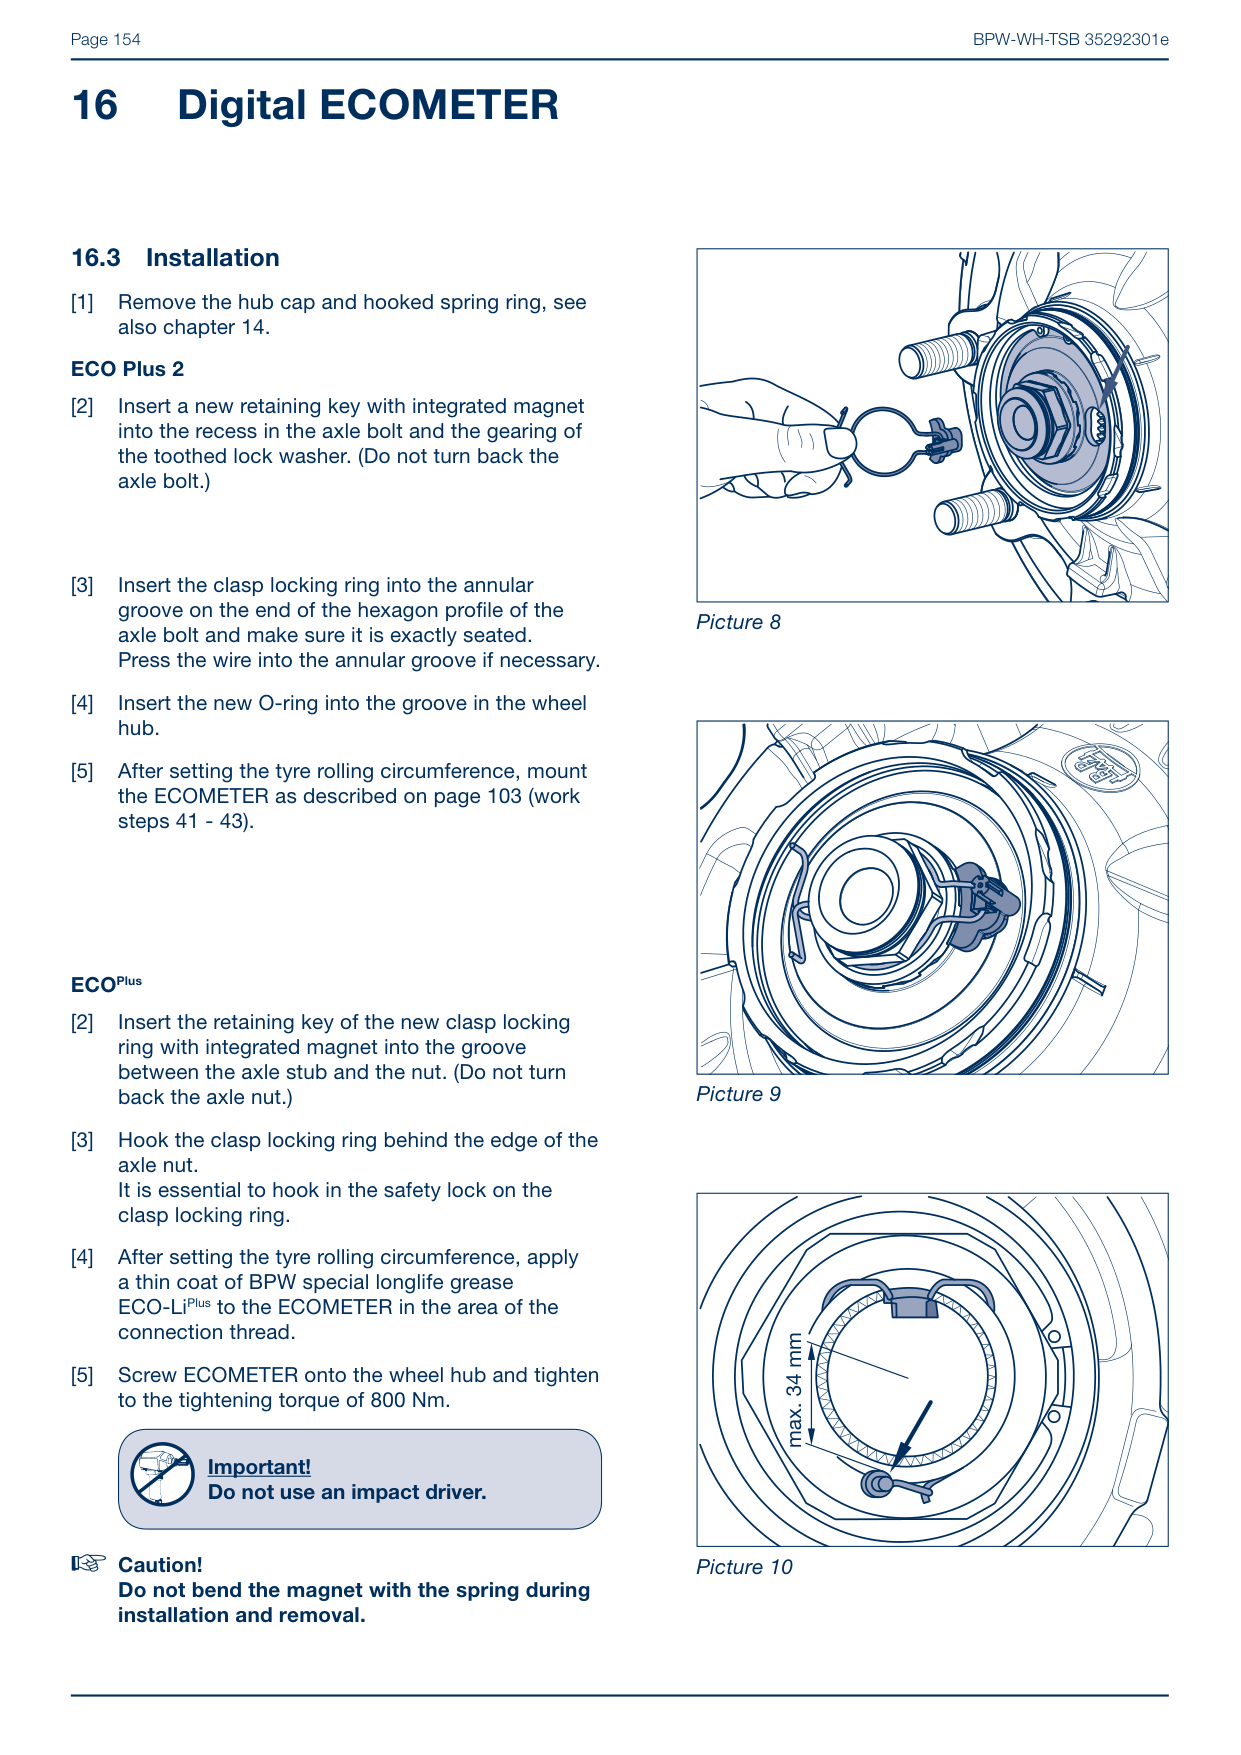

In [0]:
images[0]

In [0]:
from databricks import agents

# Register the chain to UC
uc_registered_model_info = mlflow.register_model(model_uri=logged_chain_info.model_uri, name=MODEL_NAME)

# Deploy to enable the Review APP and create an API endpoint
deployment_info = agents.deploy(model_name=MODEL_NAME_FQN.replace('`', ''), model_version=uc_registered_model_info.version, scale_to_zero=True)

instructions_to_reviewer = f"""### Instructions for Testing the Maintenance assistant

Your inputs are invaluable for the development team. By providing detailed feedback and corrections, you help us fix issues and improve the overall quality of the application. We rely on your expertise to identify any gaps or areas needing enhancement.

1. **Variety of Questions**:
   - Please try a wide range of questions that you anticipate the end users of the application will ask. This helps us ensure the application can handle the expected queries effectively.

2. **Feedback on Answers**:
   - After asking each question, use the feedback widgets provided to review the answer given by the application.
   - If you think the answer is incorrect or could be improved, please use "Edit Answer" to correct it. Your corrections will enable our team to refine the application's accuracy.

3. **Review of Returned Documents**:
   - Carefully review each document that the system returns in response to your question.
   - Use the thumbs up/down feature to indicate whether the document was relevant to the question asked. A thumbs up signifies relevance, while a thumbs down indicates the document was not useful.

Thank you for your time and effort in testing our assistant. Your contributions are essential to delivering a high-quality product to our end users."""


# Add the user-facing instructions to the Review App
agents.set_review_instructions(MODEL_NAME_FQN.replace('`', ''), instructions_to_reviewer)
wait_for_model_serving_endpoint_to_be_ready(deployment_info.endpoint_name, 5)

Registered model 'maggie' already exists. Creating a new version of this model...
2024/10/29 17:11:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: maggie, version 2
Created version '2' of model 'maggie'.


2024/10/29 17:11:12 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - databricks-vectorsearch (current: 0.42, required: databricks-vectorsearch==0.41)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.



    Deployment of test-catalog.bronze.maggie version 2 initiated.  This can take up to 15 minutes and the Review App & Query Endpoint will not work until this deployment finishes.

    View status: https://adb-4176489020682060.0.azuredatabricks.net/ml/endpoints/agents_test-catalog-bronze-maggie
    Review App: https://adb-4176489020682060.0.azuredatabricks.net/ml/review/test-catalog.bronze.maggie/2?o=4176489020682060
    
Waiting for endpoint to deploy agents_test-catalog-bronze-maggie. Current state: EndpointState(config_update=<EndpointStateConfigUpdate.IN_PROGRESS: 'IN_PROGRESS'>, ready=<EndpointStateReady.READY: 'READY'>)
Waiting for endpoint to deploy agents_test-catalog-bronze-maggie. Current state: EndpointState(config_update=<EndpointStateConfigUpdate.IN_PROGRESS: 'IN_PROGRESS'>, ready=<EndpointStateReady.READY: 'READY'>)
Waiting for endpoint to deploy agents_test-catalog-bronze-maggie. Current state: EndpointState(config_update=<EndpointStateConfigUpdate.IN_PROGRESS: 'IN_PROG

## Grant stakeholders access to the Review App

Now, grant your stakeholders permissions to use the Review App. To simplify access, stakeholders do not require to have Databricks accounts.

In [1]:
# user_list = ["quentin.ambard@databricks.com"]
# # Set the permissions.
# agents.set_permissions(model_name=MODEL_NAME_FQN, users=user_list, permission_level=agents.PermissionLevel.CAN_QUERY)

# print(f"Share this URL with your stakeholders: {deployment_info.review_app_url}")